In [1]:
# load the drive helper mount
from google.colab import drive

# this will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


ก่อนอื่น เราจะเมานต์ Google ไดรฟ์ของเราบน colab เพื่อให้เราสามารถใช้ชุดข้อมูลได้โดยตรงจากไดรฟ์ของเรา สำหรับสิ่งนี้ ก่อนอื่นคุณต้องอัปโหลดข้อมูลในไดรฟ์ของคุณ แล้วจึงต่อเชื่อมไดรฟ์บน colab

In [ ]:
# After executing the cell above, Drive files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils  import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split

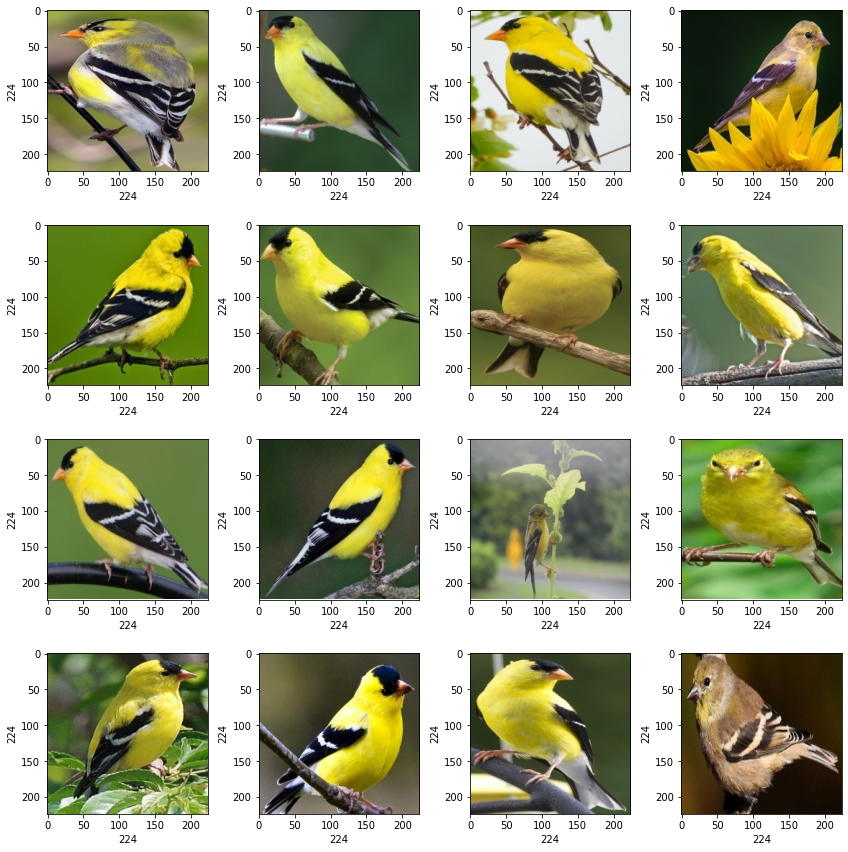

In [4]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "/content/drive/My Drive/Bird Speciees Dataset/AMERICAN GOLDFINCH"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

In [5]:
# Setting path and creating empty list
dir = "/content/drive/My Drive/Bird Speciees Dataset"
root_dir = listdir(dir)
image_list, label_list = [], []

In [6]:
# Reading and converting image to numpy array
for directory in root_dir:
  for files in listdir(f"{dir}/{directory}"):
    image_path = f"{dir}/{directory}/{files}"
    image = cv2.imread(image_path)
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

In [7]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

AMERICAN GOLDFINCH    143
EMPEROR PENGUIN       139
DOWNY WOODPECKER      137
FLAMINGO              132
CARMINE BEE-EATER     131
BARN OWL              129
dtype: int64

In [8]:
# Storing number of classes
num_classes = len(label_counts)
num_classes

6

In [9]:
# Checking input image shape
image_list[0].shape

(224, 224, 3)

In [10]:
# Checking labels shape 
label_list = np.array(label_list)
label_list.shape

(811,)

In [11]:
# Splitting dataset
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

In [12]:
# Normalize and reshape data
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 224,224,3)
x_test = x_test.reshape( -1, 224,224,3)

In [13]:
# Label binarizing
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['AMERICAN GOLDFINCH' 'BARN OWL' 'CARMINE BEE-EATER' 'DOWNY WOODPECKER'
 'EMPEROR PENGUIN' 'FLAMINGO']


In [14]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [15]:
# Building model architecture
model = Sequential()
model.add(Conv2D(8, (3, 3), padding="same",input_shape=(224,224,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 32)       0

ต่อไปเราจะสร้างสถาปัตยกรรมเครือข่ายสำหรับโมเดล เราใช้เลเยอร์ประเภทต่างๆ ตามคุณสมบัติ ได้แก่ Conv_2d (ใช้เพื่อสร้างเคอร์เนลแบบวนรอบที่รวมเข้ากับเลเยอร์อินพุตเพื่อสร้างเอาต์พุตเทนเซอร์), max_pooling2d (เป็นเทคนิคการสุ่มตัวอย่างซึ่งดึงค่าสูงสุดออกมา หน้าต่างที่กำหนดโดย poolsize), แบน (แบนอินพุตและสร้างเอาต์พุต 1D), หนาแน่น (เลเยอร์หนาแน่นสร้างเอาต์พุตเป็นผลิตภัณฑ์ดอทของอินพุตและเคอร์เนล) ในเลเยอร์สุดท้าย เราจะใช้ softmax เป็นฟังก์ชันการเปิดใช้งานเนื่องจากเป็นปัญหาการจำแนกประเภทหลายคลาส

In [16]:
# Compiling model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])

ในขณะที่รวบรวมโมเดล เราจำเป็นต้องตั้งค่าประเภทของการสูญเสียซึ่งจะเป็น Categorical Crossentropy สำหรับโมเดลของเรา ควบคู่ไปกับสิ่งนี้ เรายังจำเป็นต้องตั้งค่าเครื่องมือเพิ่มประสิทธิภาพและเมตริกตามลำดับ

In [17]:
# Training the model
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/50
5/5 [==============================] - 11s 197ms/step - loss: 1.7637 - accuracy: 0.2510 - val_loss: 1.6932 - val_accuracy: 0.3462
Epoch 2/50
5/5 [==============================] - 0s 83ms/step - loss: 1.6395 - accuracy: 0.4556 - val_loss: 1.5793 - val_accuracy: 0.4077
Epoch 3/50
5/5 [==============================] - 0s 87ms/step - loss: 1.4902 - accuracy: 0.4653 - val_loss: 1.5427 - val_accuracy: 0.3846
Epoch 4/50
5/5 [==============================] - 0s 86ms/step - loss: 1.4109 - accuracy: 0.4035 - val_loss: 1.4961 - val_accuracy: 0.4231
Epoch 5/50
5/5 [==============================] - 0s 85ms/step - loss: 1.3357 - accuracy: 0.5077 - val_loss: 1.3473 - val_accuracy: 0.5231
Epoch 6/50
5/5 [==============================] - 0s 84ms/step - loss: 1.1940 - accuracy: 0.5946 - val_loss: 1.2648 - val_accuracy: 0.5692
Epoch 7/50
5/5 [==============================] - 0s 85ms/step - loss: 1.0571 - accuracy: 0.6178 - val_loss: 1.1277 - val_accuracy: 0.5846
Epoch 8/50
5/5 [=========

ปรับโมเดลให้เข้ากับข้อมูลและค้นหาความแม่นยำในแต่ละยุคเพื่อดูว่าโมเดลของเราเรียนรู้อย่างไร ตอนนี้เราจะฝึกโมเดลของเราใน 50 ยุคและชุดขนาด 128 คุณสามารถลองใช้จำนวนยุคมากขึ้นเพื่อเพิ่มความแม่นยำ แต่ที่นี่เราจะเห็นว่าโมเดลมีความแม่นยำสูงมากแล้ว ดังนั้นเราไม่จำเป็นต้องเรียกใช้ มันมากขึ้น ในแต่ละยุค เราสามารถเห็นประสิทธิภาพของโมเดลโดยการดูการฝึกอบรมและการตรวจสอบความถูกต้อง

In [19]:
# Saving model
model.save("/content/drive/My Drive/bird_species.h5")

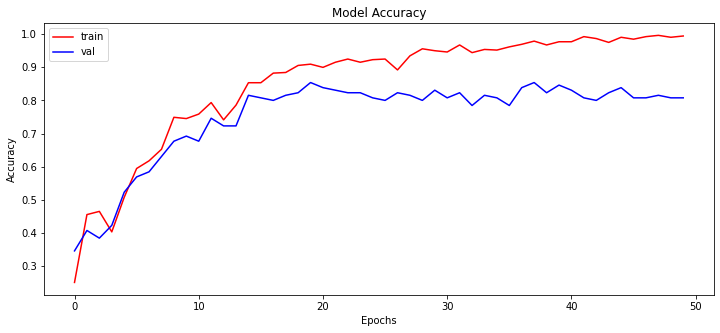

In [20]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

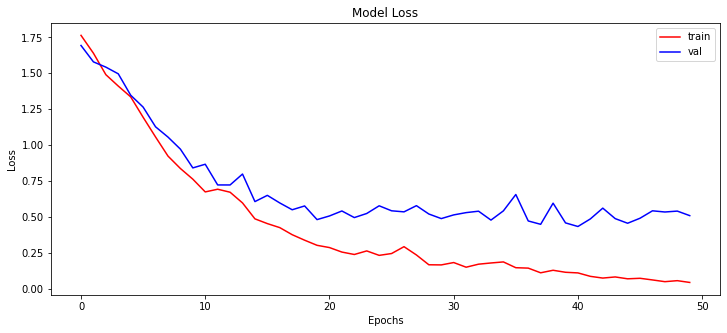

In [21]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [22]:
# Calculating test accuracy
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

6/6 [==============================] - 0s 28ms/step - loss: 0.3536 - accuracy: 0.9080
Test Accuracy: 90.7975435256958


In [23]:
# Storing predictions
y_pred = model.predict(x_test)

6/6 [==============================] - 0s 13ms/step


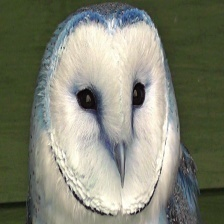

In [24]:
# Plotting image to compare
img = array_to_img(x_test[5])
img

In [25]:
# Finding max value from predition list and comaparing original value vs predicted
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[5])])
print("Predicted : ",labels[np.argmax(y_pred[5])])

['AMERICAN GOLDFINCH' 'BARN OWL' 'CARMINE BEE-EATER' 'DOWNY WOODPECKER'
 'EMPEROR PENGUIN' 'FLAMINGO']
Originally :  BARN OWL
Predicted :  BARN OWL


# Conclusion:

เราเริ่มต้นด้วยการโหลดชุดข้อมูลลงใน google colab โดยใช้ google ไดรฟ์และการแสดงภาพ การทำให้เป็นมาตรฐานเป็นขั้นตอนสำคัญเมื่อทำงานกับชุดข้อมูลทุกประเภท หลังจากนั้นเราได้สร้าง CNN Model ซึ่งใช้ในการทำนายชนิดนกต่อไปโดยใช้ภาพที่ได้ให้กับแบบจำลอง

# Scope:
โครงการนี้สามารถใช้เพื่อวัตถุประสงค์ทางการศึกษาเพื่อทำความเข้าใจวิธีสร้างสถาปัตยกรรมเครือข่ายสำหรับแบบจำลอง CNN คุณสามารถปรับแต่งพารามิเตอร์ไฮเปอร์เพิ่มเติมให้กับโมเดลนี้เพื่อให้ได้ความแม่นยำสูงขึ้น เขตรักษาพันธุ์นกสามารถใช้เพื่อระบุนกประเภทต่างๆ